# Client 1 Model (Split Federated Learning)

This notebook implements the client-side model for **Client 1** in a Split Federated Learning setup.
As per the system requirements:
1.  **Data:** Loaded locally from `datasets/Client1`.
2.  **Preprocessing:** Merges `patients`, `admissions`, `icustays` and extracts features.
3.  **Model:** A local PyTorch Encoder that outputs an intermediate vector.
4.  **Local Training:** Includes a temporary classifier head for local pretraining/debugging.

## 1. Import Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import DataLoader


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 2. Load Preprocessed Data

Earlier steps have merged and preprocessed the raw CSV files into a clean dataset. We will load this directly.

*File:* `data/processed/client1_processed.csv`

In [2]:
DATA_PATH = '../data/processed/client1_processed.csv'

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Processed data not found at {DATA_PATH}. Please run 'preprocessing/process_client_data.py' first.")

print(f"Loading data from {DATA_PATH}...")
df = pd.read_csv(DATA_PATH)
print(f"Data shape: {df.shape}")

# Inspect columns
print("Columns:", df.columns.tolist())

# Separate Features and Target
# Excluding IDs
drop_cols = ['subject_id', 'hadm_id', 'hospital_expire_flag']
feature_cols = [c for c in df.columns if c not in drop_cols]
target_col = 'hospital_expire_flag'

X = df[feature_cols].values
y = df[target_col].values

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Input dimension for model: {X.shape[1]}")

Loading data from ../data/processed/client1_processed.csv...
Data shape: (182026, 16)
Columns: ['subject_id', 'hadm_id', 'age', 'gender_encoded', 'los', 'lab_50912', 'lab_51006', 'lab_51221', 'lab_51222', 'lab_51249', 'lab_51250', 'lab_51265', 'lab_51277', 'lab_51279', 'lab_51301', 'hospital_expire_flag']
Features (X) shape: (182026, 13)
Target (y) shape: (182026,)
Input dimension for model: 13


## 3. Train/Test Split (Local)

Even though this is a client in FL, we need to evaluate its *local* performance initially. We split the client's local data into train/val sets. This is standard practice before federated rounds begin.

In [3]:
# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert to Tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1)

# DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

import pickle
import os

os.makedirs('../models', exist_ok=True)
with open('../models/client1_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler saved to ../models/client1_scaler.pkl")

Train samples: 145620
Validation samples: 36406
Scaler saved to ../models/client1_scaler.pkl


## 4. Define Client Model Architecture

This is where the "Split" happens.
1.  **ClientEncoder:** Takes raw input -> Outputs `activation`. This `activation` is what gets sent to the server in a real SFL setup.
2.  **TemporaryClassifier:** Takes `activation` -> Output prediction. This is ONLY for local pre-training and validation.

In the real Split Federated Learning round, we only use `ClientEncoder`. The gradients come back from the server to update this encoder.

In [4]:
class ClientEncoder(nn.Module):
    """
    The bottom part of the Split Neural Network.
    This resides on Client 1.
    """
    def __init__(self, input_dim, hidden_dim=64):
        super(ClientEncoder, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        # Output layer of the encoder (intermediate representation)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim // 2) 

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        return x # Returns the activation to be sent to server

class TemporaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(TemporaryClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
        # Sigmoid removed — BCEWithLogitsLoss handles it internally

    def forward(self, x):
        return self.fc(x)  # Returns raw logits
    
    
class LocalModel(nn.Module):
    """
    Combines Encoder + Classifier for local pre-training.
    """
    def __init__(self, input_dim, hidden_dim):
        super(LocalModel, self).__init__()
        self.encoder = ClientEncoder(input_dim, hidden_dim)
        self.classifier = TemporaryClassifier(hidden_dim // 2)
    
    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

input_dim = X_train.shape[1]
hidden_dim = 128

local_model = LocalModel(input_dim, hidden_dim).to(device)
# Compute pos_weight from your actual class distribution
num_negative = (y_train == 0).sum()
num_positive = (y_train == 1).sum()
pos_weight = torch.tensor([10.0], dtype=torch.float).to(device)

# BCEWithLogitsLoss = Sigmoid + BCE internally, more numerically stable
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(local_model.parameters(), lr=0.0005)

print(local_model)
print(f"Encoder output dimension (to be sent to server): {hidden_dim // 2}")

LocalModel(
  (encoder): ClientEncoder(
    (layer1): Linear(in_features=13, out_features=128, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (layer2): Linear(in_features=128, out_features=64, bias=True)
  )
  (classifier): TemporaryClassifier(
    (fc): Linear(in_features=64, out_features=1, bias=True)
  )
)
Encoder output dimension (to be sent to server): 64


## 5. Local Pre-Training Loop

We now train the `LocalModel` on Client 1's data. This ensures the `ClientEncoder` learns useful representations *before* connecting to the split server. This can significantly speed up the convergence of Split Federated Learning.

In [5]:
num_epochs = 40
train_losses = []
val_losses = []

print("Starting Local Pre-training...")

for epoch in range(num_epochs):
    local_model.train()
    running_loss = 0.0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = local_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    local_model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = local_model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    accuracy = 100 * correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Accuracy: {accuracy:.2f}%")

print("Training Complete.")

# Access just the encoder for future SFL
encoder_only = local_model.encoder
print("Client Encoder ready for Split Federated Learning.")

Starting Local Pre-training...


Epoch [1/40] | Train Loss: 0.3461 | Val Loss: 0.2997 | Accuracy: 95.58%


Epoch [2/40] | Train Loss: 0.3131 | Val Loss: 0.2942 | Accuracy: 95.78%


Epoch [3/40] | Train Loss: 0.3070 | Val Loss: 0.2864 | Accuracy: 94.64%


Epoch [4/40] | Train Loss: 0.3001 | Val Loss: 0.2868 | Accuracy: 94.89%


Epoch [5/40] | Train Loss: 0.2990 | Val Loss: 0.2791 | Accuracy: 94.72%


Epoch [6/40] | Train Loss: 0.2955 | Val Loss: 0.2847 | Accuracy: 96.35%


Epoch [7/40] | Train Loss: 0.2917 | Val Loss: 0.2763 | Accuracy: 95.31%


Epoch [8/40] | Train Loss: 0.2902 | Val Loss: 0.2750 | Accuracy: 95.88%


Epoch [9/40] | Train Loss: 0.2880 | Val Loss: 0.2750 | Accuracy: 95.81%


Epoch [10/40] | Train Loss: 0.2839 | Val Loss: 0.2847 | Accuracy: 94.16%


Epoch [11/40] | Train Loss: 0.2833 | Val Loss: 0.2719 | Accuracy: 95.37%


Epoch [12/40] | Train Loss: 0.2804 | Val Loss: 0.2729 | Accuracy: 95.29%


Epoch [13/40] | Train Loss: 0.2802 | Val Loss: 0.2711 | Accuracy: 95.43%


Epoch [14/40] | Train Loss: 0.2787 | Val Loss: 0.2703 | Accuracy: 95.77%


Epoch [15/40] | Train Loss: 0.2753 | Val Loss: 0.2708 | Accuracy: 95.87%


Epoch [16/40] | Train Loss: 0.2749 | Val Loss: 0.2666 | Accuracy: 95.30%


Epoch [17/40] | Train Loss: 0.2739 | Val Loss: 0.2700 | Accuracy: 95.63%


Epoch [18/40] | Train Loss: 0.2726 | Val Loss: 0.2680 | Accuracy: 95.22%


Epoch [19/40] | Train Loss: 0.2725 | Val Loss: 0.2663 | Accuracy: 95.63%


Epoch [20/40] | Train Loss: 0.2707 | Val Loss: 0.2704 | Accuracy: 95.74%


Epoch [21/40] | Train Loss: 0.2701 | Val Loss: 0.2674 | Accuracy: 95.17%


Epoch [22/40] | Train Loss: 0.2686 | Val Loss: 0.2679 | Accuracy: 95.27%


Epoch [23/40] | Train Loss: 0.2687 | Val Loss: 0.2668 | Accuracy: 95.69%


Epoch [24/40] | Train Loss: 0.2674 | Val Loss: 0.2655 | Accuracy: 95.58%


Epoch [25/40] | Train Loss: 0.2656 | Val Loss: 0.2654 | Accuracy: 95.92%


Epoch [26/40] | Train Loss: 0.2646 | Val Loss: 0.2658 | Accuracy: 95.79%


Epoch [27/40] | Train Loss: 0.2635 | Val Loss: 0.2644 | Accuracy: 95.49%


Epoch [28/40] | Train Loss: 0.2643 | Val Loss: 0.2679 | Accuracy: 95.94%


Epoch [29/40] | Train Loss: 0.2630 | Val Loss: 0.2675 | Accuracy: 95.46%


Epoch [30/40] | Train Loss: 0.2620 | Val Loss: 0.2663 | Accuracy: 95.56%


Epoch [31/40] | Train Loss: 0.2616 | Val Loss: 0.2689 | Accuracy: 95.94%


Epoch [32/40] | Train Loss: 0.2618 | Val Loss: 0.2659 | Accuracy: 95.66%


Epoch [33/40] | Train Loss: 0.2602 | Val Loss: 0.2635 | Accuracy: 95.27%


Epoch [34/40] | Train Loss: 0.2585 | Val Loss: 0.2634 | Accuracy: 95.45%


Epoch [35/40] | Train Loss: 0.2591 | Val Loss: 0.2672 | Accuracy: 96.09%


Epoch [36/40] | Train Loss: 0.2582 | Val Loss: 0.2684 | Accuracy: 95.47%


Epoch [37/40] | Train Loss: 0.2581 | Val Loss: 0.2671 | Accuracy: 95.78%


Epoch [38/40] | Train Loss: 0.2582 | Val Loss: 0.2646 | Accuracy: 95.48%


Epoch [39/40] | Train Loss: 0.2564 | Val Loss: 0.2665 | Accuracy: 95.11%


Epoch [40/40] | Train Loss: 0.2565 | Val Loss: 0.2662 | Accuracy: 95.50%
Training Complete.
Client Encoder ready for Split Federated Learning.


## 5b  Save the Encoder Weights
Right now your trained encoder only exists in RAM. If the kernel restarts, it's gone. Add this immediately after your training cell:

In [6]:
import os

# Save the full local model (for reference/backup)
os.makedirs('../models', exist_ok=True)
torch.save(local_model.state_dict(), '../models/client1_local_model.pth')

# Save ONLY the encoder (this is what SFL actually uses)
torch.save(local_model.encoder.state_dict(), '../models/client1_encoder.pth')

print("Encoder saved. Activation output dim: 64")
print(f"Encoder parameter count: {sum(p.numel() for p in local_model.encoder.parameters())}")

Encoder saved. Activation output dim: 64
Encoder parameter count: 10048


## 6. Detailed Evaluation
Calculate Confusion Matrix, Classification Report, and ROC-AUC to better evaluate the model performance.

Precision-Recall AUC: 0.4124


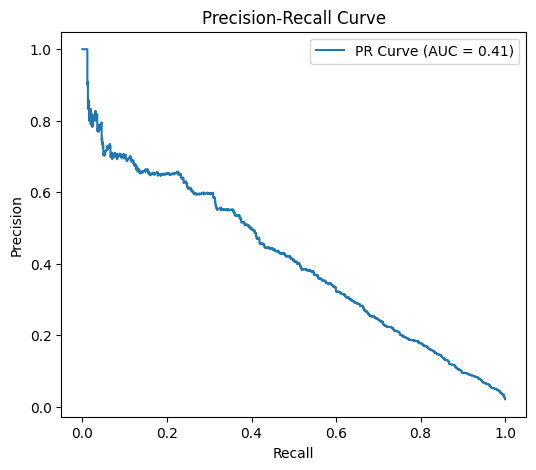

ROC-AUC Score: 0.9415
Optimal Threshold (max F1 for Expired): 0.7282


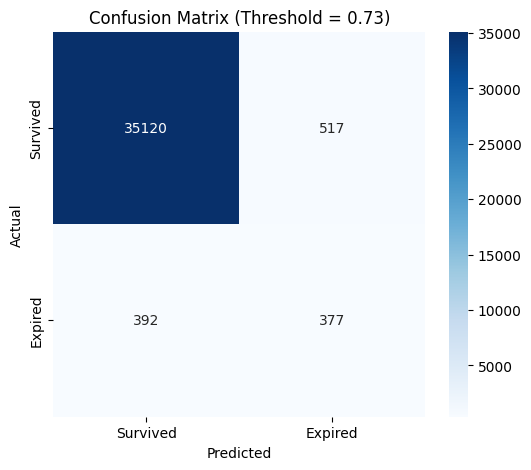


Classification Report:

              precision    recall  f1-score   support

    Survived       0.99      0.99      0.99     35637
     Expired       0.42      0.49      0.45       769

    accuracy                           0.98     36406
   macro avg       0.71      0.74      0.72     36406
weighted avg       0.98      0.98      0.98     36406



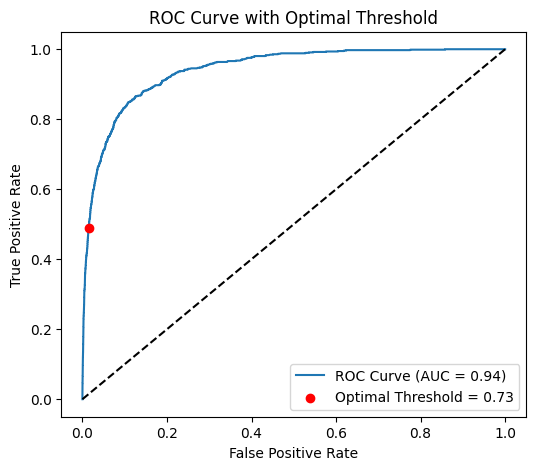

In [7]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

local_model.eval()
all_probs = []
all_targets = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = local_model(inputs)
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

all_probs = np.array(all_probs).flatten()
all_targets = np.array(all_targets).flatten()

# -- Precision Recall --

precision_vals, recall_vals, pr_thresholds = precision_recall_curve(all_targets, all_probs)
pr_auc = average_precision_score(all_targets, all_probs)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# --- ROC-AUC ---
roc_auc = roc_auc_score(all_targets, all_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# --- Find Optimal Threshold via F1 for Minority Class ---
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)

f1_scores = []
for t in thresholds:
    preds = (all_probs >= t).astype(float)
    f1 = f1_score(all_targets, preds, pos_label=1, zero_division=0)
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (max F1 for Expired): {optimal_threshold:.4f}")

# --- Final Predictions at Optimal Threshold ---
final_preds = (all_probs >= optimal_threshold).astype(float)

# --- Confusion Matrix ---
cm = confusion_matrix(all_targets, final_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Survived', 'Expired'],
            yticklabels=['Survived', 'Expired'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {optimal_threshold:.2f})')
plt.show()

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(all_targets, final_preds, target_names=['Survived', 'Expired']))

# --- ROC Curve with Optimal Point Marked ---
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red',
            label=f'Optimal Threshold = {optimal_threshold:.2f}', zorder=5)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Threshold')
plt.legend()
plt.show()

## 7. Simulate Split Learning Payload
To answer the question "Is it generating the correct activation vector?", we can simulate the "split" step.
We will take a single batch of data, pass it through the **Encoder only**, and inspect the output.
In the real Federated Learning setup, this `start_activations` tensor is exactly what gets sent to the server.

In [9]:

# 1. Get a batch of data
client_data_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)
data_iter = iter(client_data_loader)
inputs, labels = next(data_iter)
inputs = inputs.to(device)

# 2. Run ONLY the Client Encoder
encoder = local_model.encoder
encoder.eval()

with torch.no_grad():
    failed_attempts = 0 # Just for safety against network issues
    activations = encoder(inputs)


def get_activation_for_server(encoder, inputs):
    """
    Produces activation vector WITH gradient tracking.
    This is what you call in real SFL rounds — NOT inside torch.no_grad().
    The returned tensor must stay in memory until the server returns gradients.
    """
    encoder.train()  # Keep dropout active during federated training
    activations = encoder(inputs)  # requires_grad=True automatically since encoder params require grad
    return activations  # Shape: [batch_size, 64]

# Test it
sample_inputs, sample_labels = next(iter(train_loader))
sample_inputs = sample_inputs.to(device)

activations = get_activation_for_server(local_model.encoder, sample_inputs)

print(f"Activation shape: {activations.shape}")           # [64, 64]
print(f"Requires grad: {activations.requires_grad}")      # Must be True
print(f"Grad fn exists: {activations.grad_fn is not None}") # Must be True

print("--- Split Learning Simulation ---")
print(f"Input batch shape: {inputs.shape}")
print(f"Activation (smashed data) shape: {activations.shape}")
print(f"\nThis activation tensor of size {activations.size()} is what will be sent to the Server.")

print("\nSample of the first activation vector (first 20 values):")
print(activations[0, :20].detach().cpu().numpy())

# Verify we aren't sending the raw data
assert activations.shape[1] != inputs.shape[1], "Error: Activation shape matches input shape!"
print("\nSuccess: The activation dimension is different from the input dimension, meaning data is encoded.")

Activation shape: torch.Size([64, 64])
Requires grad: True
Grad fn exists: True
--- Split Learning Simulation ---
Input batch shape: torch.Size([5, 13])
Activation (smashed data) shape: torch.Size([64, 64])

This activation tensor of size torch.Size([64, 64]) is what will be sent to the Server.

Sample of the first activation vector (first 20 values):
[3.9658902  0.         1.8527105  0.         0.         0.
 3.1145432  0.         1.4597955  0.         0.         0.13772014
 0.8763528  0.         0.         3.3432379  0.         0.44477603
 3.5061078  0.        ]

Success: The activation dimension is different from the input dimension, meaning data is encoded.
